Upload traffic video


Saving 455409_Brussels_Bruxelles_1920x1080.mp4 to 455409_Brussels_Bruxelles_1920x1080 (1).mp4


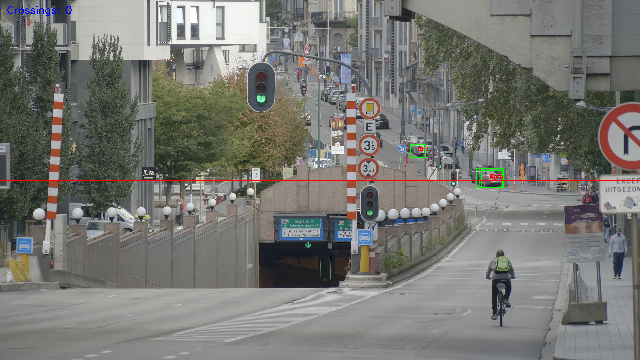

Processing frame: 0
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Processing frame: 100
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Processing frame: 200
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!
Vehicle 0 crossed line!


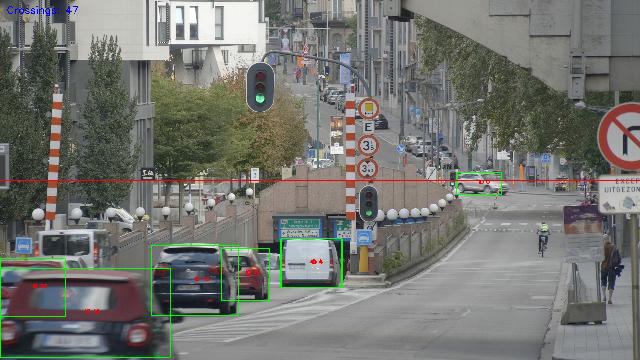

Processing frame: 300
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Vehicle 24 crossed line!
Veh

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ================================
# Install libraries
# ================================
!pip -q install ultralytics opencv-python-headless

# ================================
# Imports
# ================================
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab import files
from google.colab.patches import cv2_imshow

# ================================
# Upload video
# ================================
print("Upload traffic video")
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ================================
# Load model
# ================================
model = YOLO("yolov8n.pt")

# ================================
# Video setup
# ================================
cap = cv2.VideoCapture(video_path)

width = int(cap.get(3))
height = int(cap.get(4))
fps = max(1, int(cap.get(cv2.CAP_PROP_FPS)))

out = cv2.VideoWriter(
    "output.mp4",
    cv2.VideoWriter_fourcc(*'mp4v'),
    fps,
    (width, height)
)

# ================================
# Virtual red line + tracking
# ================================
line_y = height // 2

object_tracks = {}
next_id = 0

def get_centroid(box):
    x1,y1,x2,y2 = box
    return int((x1+x2)/2), int((y1+y2)/2)

def match_object(centroid):
    global next_id
    for obj_id, prev in object_tracks.items():
        dist = np.linalg.norm(np.array(centroid)-np.array(prev))
        if dist < 50:
            return obj_id
    object_tracks[next_id] = centroid
    next_id += 1
    return next_id-1

# ================================
# Preview control (IMPORTANT)
# ================================
MAX_PREVIEWS = 5
preview_interval = 300
preview_count = 0

frame_count = 0
cross_count = 0

# ================================
# Processing loop
# ================================
while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, verbose=False)

    for r in results:
        for box in r.boxes.data:

            x1,y1,x2,y2,conf,cls = box.tolist()
            cls = int(cls)

            # vehicle classes
            if cls in [2,3,5,7]:

                centroid = get_centroid((x1,y1,x2,y2))
                obj_id = match_object(centroid)

                prev_y = object_tracks[obj_id][1]
                object_tracks[obj_id] = centroid

                # line crossing detection
                if prev_y < line_y and centroid[1] >= line_y:
                    cross_count += 1
                    print(f"Vehicle {obj_id} crossed line!")

                # draw detection
                cv2.rectangle(frame,(int(x1),int(y1)),
                              (int(x2),int(y2)),(0,255,0),2)

                cv2.putText(frame,f"ID {obj_id}",
                            centroid,
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,(0,0,255),2)

    # draw line + counter
    cv2.line(frame,(0,line_y),(width,line_y),(0,0,255),2)

    cv2.putText(frame,f"Crossings: {cross_count}",
                (20,40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,(255,0,0),2)

    out.write(frame)

    # ⭐ Show only important previews
    if frame_count % preview_interval == 0 and preview_count < MAX_PREVIEWS:

        small = cv2.resize(frame,(640,360))
        cv2_imshow(small)

        # save snapshot externally
        cv2.imwrite(f"traffic_snapshot_{preview_count}.jpg", frame)

        preview_count += 1

    # progress update
    if frame_count % 100 == 0:
        print("Processing frame:", frame_count)

    frame_count += 1

# ================================
# Cleanup
# ================================
cap.release()
out.release()

print("\n✅ Processing complete!")

# ================================
# Download result
# ================================
files.download("output.mp4")
